# Bias Removal

Climate models can have biases relative to different verification datasets. Commonly, biases are removed by postprocessing before verification of forecasting skill. `climpred` provides convenience functions to do so.

In [1]:
import climpred
import xarray as xr
import matplotlib.pyplot as plt
from climpred import HindcastEnsemble

In [2]:
hind = climpred.tutorial.load_dataset('CESM-DP-SST') # CESM-DPLE hindcast ensemble output.
recon = climpred.tutorial.load_dataset('FOSI-SST') # Reconstruction simulation that initialized CESM-DPLE.
hind["lead"].attrs["units"] = "years"
v='SST'
alignment='same_verif'

We begin by removing a mean climatology for the reconstruction, since `CESM-DPLE` generates its anomalies over this same time period.

In [3]:
recon = recon - recon.sel(time=slice('1964', '2014')).mean('time')

/Users/rileybrady/Desktop/dev/climpred/climpred/utils.py:141: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  "Assuming annual resolution due to numeric inits. "


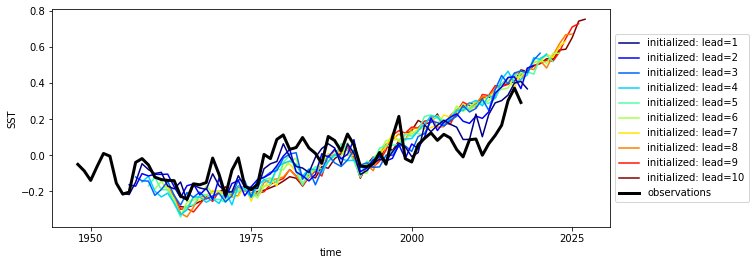

In [4]:
hindcast = HindcastEnsemble(hind)
hindcast = hindcast.add_observations(recon)
hindcast.plot()

The warming of the `reconstruction` is less than the `initialized`.

## Mean bias removal

Typically, bias depends on lead-time and therefore should therefore also be removed depending on lead-time.

In [5]:
# build bias_metric by hand
from climpred.metrics import Metric
def bias_func(a,b,**kwargs):
    return a-b
bias_metric = Metric('bias', bias_func, True, False,1)

In [6]:
bias = hindcast.verify(metric=bias_metric, comparison='e2r', dim='init', alignment=alignment).squeeze()

In [7]:
# equals using the pre-defined (unconditional) bias metric applied to over dimension member
xr.testing.assert_allclose(bias, hindcast.verify(metric='unconditional_bias', comparison='m2r',dim='member', alignment=alignment).squeeze())

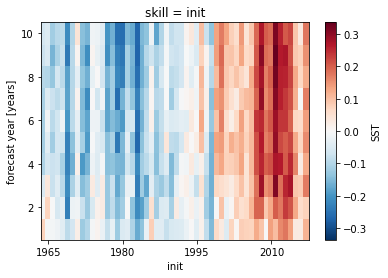

In [8]:
bias[v].plot()

- against `reconstruction`: Cold bias in early years and warm bias in later years.

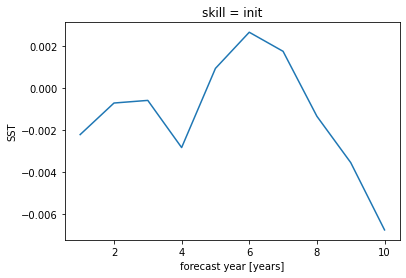

In [9]:
# lead-time dependant mean bias over all initializations is quite small
mean_bias = bias.mean('init')
mean_bias[v].plot()

### Cross Validatation
To remove the mean bias quickly, the mean bias over all initializations is subtracted, see `_mean_bias_removal_quick`. For formally correct bias removal with cross validation, the given initialization is left out when subtracting the mean bias, see `_mean_bias_removal_cross_validate`.

`climpred` wraps these functions in `HindcastEnsemble.remove_bias(how='mean', cross_validate={bool})`.

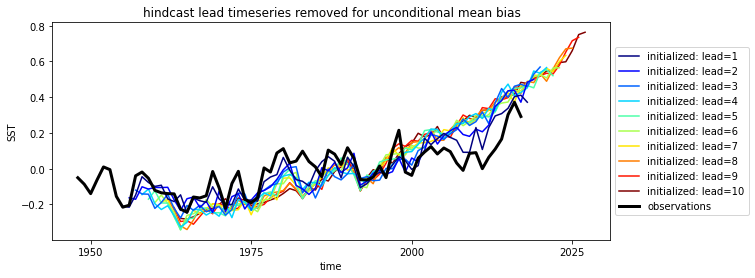

In [10]:
hindcast.remove_bias(how='mean', cross_validate=True, alignment=alignment).plot()
plt.title('hindcast lead timeseries removed for unconditional mean bias')
plt.show()

## Skill

Distance-based accuracy metrics like (`mse`,`rmse`,`nrmse`,...) are sensitive to mean bias removal. Correlations like (`pearson_r`, `spearman_r`) are insensitive to bias correction.

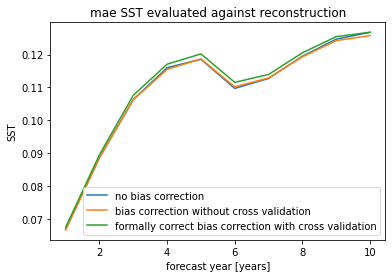

In [11]:
metric='mae'
hindcast.verify(metric=metric, comparison='e2o', dim='init', alignment=alignment)[v].plot(label='no bias correction')
hindcast.remove_bias(cross_validate=False, alignment=alignment).verify(metric=metric, comparison='e2o', dim='init', alignment=alignment)[v].plot(label='bias correction without cross validation')
hindcast.remove_bias(cross_validate=True, alignment=alignment).verify(metric=metric, comparison='e2o', dim='init', alignment=alignment)[v].plot(label='formally correct bias correction with cross validation')
plt.legend()
plt.title(f"{metric} {v} evaluated against reconstruction")
plt.show()